<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB2] - First convolutions
<!-- DESC --> Episode 2 : First convolutions and first classification of our traffic signs
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Recognizing traffic signs 
  - Understand the **principles** and **architecture** of a **convolutional neural network** for image classification
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


**IMPORTANT :** To be able to use this notebook and the following, **you must have generated the enhanced datasets** in <dataset_dir>/enhanced via the notebook **[01-Preparation-of-data.ipynb](01-Preparation-of-data.ipynb)**  

## What we're going to do :

 - Read H5 dataset
 - Build a model
 - Train the model
 - Evaluate the model

## Step 1 - Import and init
### 1.1 - Python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os,time,sys

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB2.001'
datasets_dir = pwk.init('GTSRB2', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB2_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : GTSRB2
Run time             : Wednesday 27 January 2021, 18:27:34
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB2_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB2_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  **3'30** on a CPU laptop.

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

# enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
We're going to retrieve a previously recorded dataset.  
For example: set-24x24-L

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:01 513ms)


## Step 3 - Have a look to the dataset
We take a quick look as we go by...

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


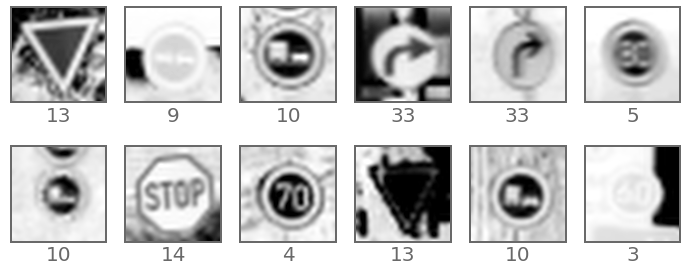

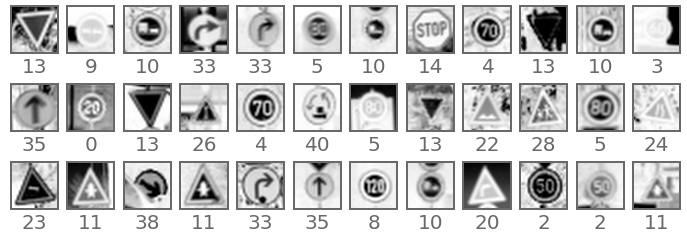

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models :

In [6]:

# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

# My sphisticated model, but small and fast
#
def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

**Train it :**

In [9]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = (x_test, y_test))

pwk.chrono_show()

Epoch 1/5


  1/613 [..............................] - ETA: 0s - loss: 3.7869 - accuracy: 0.0000e+00

 18/613 [..............................] - ETA: 1s - loss: 3.5913 - accuracy: 0.0599    

 36/613 [>.............................] - ETA: 1s - loss: 3.5373 - accuracy: 0.0734

 54/613 [=>............................] - ETA: 1s - loss: 3.4915 - accuracy: 0.0900

 72/613 [==>...........................] - ETA: 1s - loss: 3.4248 - accuracy: 0.1083

 90/613 [===>..........................] - ETA: 1s - loss: 3.3235 - accuracy: 0.1361

109/613 [====>.........................] - ETA: 1s - loss: 3.1845 - accuracy: 0.1712

128/613 [=====>........................] - ETA: 1s - loss: 3.0393 - accuracy: 0.2069

147/613 [======>.......................] - ETA: 1s - loss: 2.8779 - accuracy: 0.2448

166/613 [=======>......................] - ETA: 1s - loss: 2.7268 - accuracy: 0.2803

185/613 [========>.....................] - ETA: 1s - loss: 2.5884 - accuracy: 0.3132

204/613 [========>.....................] - ETA: 1s - loss: 2.4644 - accuracy: 0.3438

223/613 [=========>....................] - ETA: 1s - loss: 2.3509 - accuracy: 0.3723

242/613 [==========>...................] - ETA: 1s - loss: 2.2502 - accuracy: 0.3970

261/613 [===========>..................] - ETA: 0s - loss: 2.1523 - accuracy: 0.4212

280/613 [============>.................] - ETA: 0s - loss: 2.0665 - accuracy: 0.4417

299/613 [=============>................] - ETA: 0s - loss: 1.9862 - accuracy: 0.4629

318/613 [==============>...............] - ETA: 0s - loss: 1.9138 - accuracy: 0.4805

337/613 [===============>..............] - ETA: 0s - loss: 1.8459 - accuracy: 0.4977

356/613 [================>.............] - ETA: 0s - loss: 1.7788 - accuracy: 0.5148

375/613 [=================>............] - ETA: 0s - loss: 1.7227 - accuracy: 0.5297

394/613 [==================>...........] - ETA: 0s - loss: 1.6669 - accuracy: 0.5444

413/613 [===================>..........] - ETA: 0s - loss: 1.6137 - accuracy: 0.5583

432/613 [====================>.........] - ETA: 0s - loss: 1.5670 - accuracy: 0.5709

451/613 [=====================>........] - ETA: 0s - loss: 1.5218 - accuracy: 0.5830

470/613 [======================>.......] - ETA: 0s - loss: 1.4816 - accuracy: 0.5935

489/613 [======================>.......] - ETA: 0s - loss: 1.4426 - accuracy: 0.6039

508/613 [=======================>......] - ETA: 0s - loss: 1.4064 - accuracy: 0.6135

527/613 [========================>.....] - ETA: 0s - loss: 1.3709 - accuracy: 0.6231

546/613 [=========================>....] - ETA: 0s - loss: 1.3378 - accuracy: 0.6318

565/613 [==========================>...] - ETA: 0s - loss: 1.3068 - accuracy: 0.6402

584/613 [===========================>..] - ETA: 0s - loss: 1.2767 - accuracy: 0.6481

603/613 [============================>.] - ETA: 0s - loss: 1.2485 - accuracy: 0.6556

613/613 [==============================] - ETA: 0s - loss: 1.2339 - accuracy: 0.6596

613/613 [==============================] - 2s 4ms/step - loss: 1.2339 - accuracy: 0.6596 - val_loss: 0.4680 - val_accuracy: 0.8873


Epoch 2/5
  1/613 [..............................] - ETA: 0s - loss: 0.5668 - accuracy: 0.8281

 20/613 [..............................] - ETA: 1s - loss: 0.3413 - accuracy: 0.8945

 39/613 [>.............................] - ETA: 1s - loss: 0.3580 - accuracy: 0.8982

 58/613 [=>............................] - ETA: 1s - loss: 0.3454 - accuracy: 0.9017

 77/613 [==>...........................] - ETA: 1s - loss: 0.3208 - accuracy: 0.9087

 96/613 [===>..........................] - ETA: 1s - loss: 0.3200 - accuracy: 0.9067

115/613 [====>.........................] - ETA: 1s - loss: 0.3131 - accuracy: 0.9080

134/613 [=====>........................] - ETA: 1s - loss: 0.3072 - accuracy: 0.9095

153/613 [======>.......................] - ETA: 1s - loss: 0.2957 - accuracy: 0.9132

172/613 [=======>......................] - ETA: 1s - loss: 0.2882 - accuracy: 0.9158

191/613 [========>.....................] - ETA: 1s - loss: 0.2862 - accuracy: 0.9158

210/613 [=========>....................] - ETA: 1s - loss: 0.2819 - accuracy: 0.9172

229/613 [==========>...................] - ETA: 1s - loss: 0.2818 - accuracy: 0.9179

248/613 [===========>..................] - ETA: 0s - loss: 0.2771 - accuracy: 0.9194

267/613 [============>.................] - ETA: 0s - loss: 0.2720 - accuracy: 0.9208

286/613 [============>.................] - ETA: 0s - loss: 0.2683 - accuracy: 0.9219

305/613 [=============>................] - ETA: 0s - loss: 0.2656 - accuracy: 0.9229

324/613 [==============>...............] - ETA: 0s - loss: 0.2616 - accuracy: 0.9241

343/613 [===============>..............] - ETA: 0s - loss: 0.2583 - accuracy: 0.9248

362/613 [================>.............] - ETA: 0s - loss: 0.2568 - accuracy: 0.9255

381/613 [=================>............] - ETA: 0s - loss: 0.2529 - accuracy: 0.9266

400/613 [==================>...........] - ETA: 0s - loss: 0.2487 - accuracy: 0.9278

419/613 [===================>..........] - ETA: 0s - loss: 0.2473 - accuracy: 0.9278

438/613 [====================>.........] - ETA: 0s - loss: 0.2454 - accuracy: 0.9282

457/613 [=====================>........] - ETA: 0s - loss: 0.2436 - accuracy: 0.9289

476/613 [======================>.......] - ETA: 0s - loss: 0.2424 - accuracy: 0.9293

495/613 [=======================>......] - ETA: 0s - loss: 0.2401 - accuracy: 0.9300

514/613 [========================>.....] - ETA: 0s - loss: 0.2375 - accuracy: 0.9306

533/613 [=========================>....] - ETA: 0s - loss: 0.2362 - accuracy: 0.9310

552/613 [==========================>...] - ETA: 0s - loss: 0.2354 - accuracy: 0.9314

571/613 [==========================>...] - ETA: 0s - loss: 0.2336 - accuracy: 0.9320

590/613 [===========================>..] - ETA: 0s - loss: 0.2320 - accuracy: 0.9326

609/613 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9332

613/613 [==============================] - 2s 3ms/step - loss: 0.2293 - accuracy: 0.9334 - val_loss: 0.3359 - val_accuracy: 0.9214


Epoch 3/5
  1/613 [..............................] - ETA: 0s - loss: 0.2166 - accuracy: 0.9219

 20/613 [..............................] - ETA: 1s - loss: 0.1451 - accuracy: 0.9609

 39/613 [>.............................] - ETA: 1s - loss: 0.1383 - accuracy: 0.9599

 58/613 [=>............................] - ETA: 1s - loss: 0.1418 - accuracy: 0.9582

 77/613 [==>...........................] - ETA: 1s - loss: 0.1456 - accuracy: 0.9582

 96/613 [===>..........................] - ETA: 1s - loss: 0.1479 - accuracy: 0.9564

115/613 [====>.........................] - ETA: 1s - loss: 0.1477 - accuracy: 0.9557

134/613 [=====>........................] - ETA: 1s - loss: 0.1472 - accuracy: 0.9559

153/613 [======>.......................] - ETA: 1s - loss: 0.1503 - accuracy: 0.9552

172/613 [=======>......................] - ETA: 1s - loss: 0.1496 - accuracy: 0.9559

191/613 [========>.....................] - ETA: 1s - loss: 0.1477 - accuracy: 0.9565

210/613 [=========>....................] - ETA: 1s - loss: 0.1459 - accuracy: 0.9574

229/613 [==========>...................] - ETA: 1s - loss: 0.1452 - accuracy: 0.9575

248/613 [===========>..................] - ETA: 0s - loss: 0.1427 - accuracy: 0.9584

267/613 [============>.................] - ETA: 0s - loss: 0.1401 - accuracy: 0.9587

286/613 [============>.................] - ETA: 0s - loss: 0.1401 - accuracy: 0.9586

305/613 [=============>................] - ETA: 0s - loss: 0.1386 - accuracy: 0.9590

324/613 [==============>...............] - ETA: 0s - loss: 0.1367 - accuracy: 0.9599

343/613 [===============>..............] - ETA: 0s - loss: 0.1373 - accuracy: 0.9597

362/613 [================>.............] - ETA: 0s - loss: 0.1364 - accuracy: 0.9602

381/613 [=================>............] - ETA: 0s - loss: 0.1353 - accuracy: 0.9606

400/613 [==================>...........] - ETA: 0s - loss: 0.1352 - accuracy: 0.9608

419/613 [===================>..........] - ETA: 0s - loss: 0.1343 - accuracy: 0.9609

438/613 [====================>.........] - ETA: 0s - loss: 0.1338 - accuracy: 0.9613

457/613 [=====================>........] - ETA: 0s - loss: 0.1340 - accuracy: 0.9610

476/613 [======================>.......] - ETA: 0s - loss: 0.1334 - accuracy: 0.9611

495/613 [=======================>......] - ETA: 0s - loss: 0.1339 - accuracy: 0.9610

514/613 [========================>.....] - ETA: 0s - loss: 0.1328 - accuracy: 0.9613

533/613 [=========================>....] - ETA: 0s - loss: 0.1320 - accuracy: 0.9615

552/613 [==========================>...] - ETA: 0s - loss: 0.1315 - accuracy: 0.9617

571/613 [==========================>...] - ETA: 0s - loss: 0.1314 - accuracy: 0.9619

590/613 [===========================>..] - ETA: 0s - loss: 0.1314 - accuracy: 0.9617

609/613 [============================>.] - ETA: 0s - loss: 0.1309 - accuracy: 0.9618

613/613 [==============================] - 2s 3ms/step - loss: 0.1306 - accuracy: 0.9619 - val_loss: 0.2538 - val_accuracy: 0.9409


Epoch 4/5
  1/613 [..............................] - ETA: 0s - loss: 0.2957 - accuracy: 0.9062

 20/613 [..............................] - ETA: 1s - loss: 0.0999 - accuracy: 0.9688

 39/613 [>.............................] - ETA: 1s - loss: 0.0995 - accuracy: 0.9704

 58/613 [=>............................] - ETA: 1s - loss: 0.0964 - accuracy: 0.9725

 77/613 [==>...........................] - ETA: 1s - loss: 0.0934 - accuracy: 0.9724

 96/613 [===>..........................] - ETA: 1s - loss: 0.0980 - accuracy: 0.9718

115/613 [====>.........................] - ETA: 1s - loss: 0.0961 - accuracy: 0.9719

134/613 [=====>........................] - ETA: 1s - loss: 0.0944 - accuracy: 0.9721

153/613 [======>.......................] - ETA: 1s - loss: 0.0950 - accuracy: 0.9717

172/613 [=======>......................] - ETA: 1s - loss: 0.0938 - accuracy: 0.9719

191/613 [========>.....................] - ETA: 1s - loss: 0.0929 - accuracy: 0.9724

210/613 [=========>....................] - ETA: 1s - loss: 0.0946 - accuracy: 0.9721

229/613 [==========>...................] - ETA: 1s - loss: 0.0945 - accuracy: 0.9725

248/613 [===========>..................] - ETA: 0s - loss: 0.0939 - accuracy: 0.9729

267/613 [============>.................] - ETA: 0s - loss: 0.0940 - accuracy: 0.9725

286/613 [============>.................] - ETA: 0s - loss: 0.0954 - accuracy: 0.9720

305/613 [=============>................] - ETA: 0s - loss: 0.0949 - accuracy: 0.9723

324/613 [==============>...............] - ETA: 0s - loss: 0.0950 - accuracy: 0.9717

343/613 [===============>..............] - ETA: 0s - loss: 0.0943 - accuracy: 0.9720

362/613 [================>.............] - ETA: 0s - loss: 0.0946 - accuracy: 0.9719

381/613 [=================>............] - ETA: 0s - loss: 0.0947 - accuracy: 0.9720

400/613 [==================>...........] - ETA: 0s - loss: 0.0945 - accuracy: 0.9722

419/613 [===================>..........] - ETA: 0s - loss: 0.0947 - accuracy: 0.9724

438/613 [====================>.........] - ETA: 0s - loss: 0.0940 - accuracy: 0.9726

457/613 [=====================>........] - ETA: 0s - loss: 0.0937 - accuracy: 0.9727

476/613 [======================>.......] - ETA: 0s - loss: 0.0934 - accuracy: 0.9731

495/613 [=======================>......] - ETA: 0s - loss: 0.0934 - accuracy: 0.9731

514/613 [========================>.....] - ETA: 0s - loss: 0.0934 - accuracy: 0.9732

533/613 [=========================>....] - ETA: 0s - loss: 0.0935 - accuracy: 0.9733

552/613 [==========================>...] - ETA: 0s - loss: 0.0931 - accuracy: 0.9733

571/613 [==========================>...] - ETA: 0s - loss: 0.0936 - accuracy: 0.9732

590/613 [===========================>..] - ETA: 0s - loss: 0.0937 - accuracy: 0.9731

609/613 [============================>.] - ETA: 0s - loss: 0.0937 - accuracy: 0.9731

613/613 [==============================] - 2s 3ms/step - loss: 0.0935 - accuracy: 0.9732 - val_loss: 0.2548 - val_accuracy: 0.9423


Epoch 5/5
  1/613 [..............................] - ETA: 0s - loss: 0.0648 - accuracy: 0.9688

 20/613 [..............................] - ETA: 1s - loss: 0.0852 - accuracy: 0.9727

 39/613 [>.............................] - ETA: 1s - loss: 0.0863 - accuracy: 0.9716

 58/613 [=>............................] - ETA: 1s - loss: 0.0809 - accuracy: 0.9752

 77/613 [==>...........................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9765

 96/613 [===>..........................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9764

115/613 [====>.........................] - ETA: 1s - loss: 0.0788 - accuracy: 0.9764

134/613 [=====>........................] - ETA: 1s - loss: 0.0762 - accuracy: 0.9768

153/613 [======>.......................] - ETA: 1s - loss: 0.0728 - accuracy: 0.9778

172/613 [=======>......................] - ETA: 1s - loss: 0.0718 - accuracy: 0.9779

191/613 [========>.....................] - ETA: 1s - loss: 0.0721 - accuracy: 0.9777

210/613 [=========>....................] - ETA: 1s - loss: 0.0706 - accuracy: 0.9782

229/613 [==========>...................] - ETA: 1s - loss: 0.0716 - accuracy: 0.9778

248/613 [===========>..................] - ETA: 1s - loss: 0.0711 - accuracy: 0.9778

267/613 [============>.................] - ETA: 0s - loss: 0.0719 - accuracy: 0.9777

286/613 [============>.................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9776

305/613 [=============>................] - ETA: 0s - loss: 0.0717 - accuracy: 0.9778

324/613 [==============>...............] - ETA: 0s - loss: 0.0723 - accuracy: 0.9777

343/613 [===============>..............] - ETA: 0s - loss: 0.0724 - accuracy: 0.9778

362/613 [================>.............] - ETA: 0s - loss: 0.0723 - accuracy: 0.9776

381/613 [=================>............] - ETA: 0s - loss: 0.0728 - accuracy: 0.9776

400/613 [==================>...........] - ETA: 0s - loss: 0.0725 - accuracy: 0.9777

419/613 [===================>..........] - ETA: 0s - loss: 0.0726 - accuracy: 0.9777

438/613 [====================>.........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9778

457/613 [=====================>........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9778

476/613 [======================>.......] - ETA: 0s - loss: 0.0722 - accuracy: 0.9781

495/613 [=======================>......] - ETA: 0s - loss: 0.0722 - accuracy: 0.9781

514/613 [========================>.....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9783

533/613 [=========================>....] - ETA: 0s - loss: 0.0717 - accuracy: 0.9782

552/613 [==========================>...] - ETA: 0s - loss: 0.0712 - accuracy: 0.9783

571/613 [==========================>...] - ETA: 0s - loss: 0.0715 - accuracy: 0.9782

590/613 [===========================>..] - ETA: 0s - loss: 0.0715 - accuracy: 0.9782

609/613 [============================>.] - ETA: 0s - loss: 0.0716 - accuracy: 0.9782

613/613 [==============================] - 2s 3ms/step - loss: 0.0715 - accuracy: 0.9783 - val_loss: 0.2370 - val_accuracy: 0.9442



Duration :  00:00:14 903ms


**Evaluate it :**

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9442


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2370
Test accuracy  : 0.9442


In [12]:
pwk.end()

End time is : Wednesday 27 January 2021, 18:27:58
Duration is : 00:00:24 764ms
This notebook ends here


<div class="todo">
    What you can do:
    <ul>
        <li>Try the different models</li>
        <li>Try with different datasets</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>Create your own model</li>
    </ul>
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>